In [5]:
! pip install pandas numpy matplotlib seaborn scikit-learn


     ---------------------------------------- 7.8/7.8 MB 2.1 MB/s eta 0:00:00
     -------------------------------------- 294.9/294.9 KB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 11.0/11.0 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 KB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 5.3 MB/s eta 0:00:00
     -------------------------------------- 211.8/211.8 KB 2.6 MB/s eta 0:00:00
     -------------------------------------- 104.1/104.1 KB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 3.5 MB/s eta 0:00:00
     -------------------------------------- 301.8/301.8 KB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 6.8 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\MonishKumar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the CSV files generated from your dataset
employees_df = pd.read_csv('employees.csv')
courses_df = pd.read_csv('courses.csv')
chapters_df = pd.read_csv('chapters.csv')
user_progress_df = pd.read_csv('user_progress.csv')
purchases_df = pd.read_csv('purchases.csv')
feedback_df = pd.read_csv('feedback.csv')
quiz_scores_df = pd.read_csv('quiz_scores.csv')
discussions_df = pd.read_csv('discussions.csv')
messages_df = pd.read_csv('messages.csv')

# Display the structure of the data
employees_df.head(), courses_df.head(), user_progress_df.head()


(                                     id             name  \
 0  9bef853d-02f7-4f7c-8064-1aeaf1e359e4      Brian Lopez   
 1  3c0cd2cf-796a-45d1-89aa-4a28216ffbaa  Cheryl Sandoval   
 2  6a37a940-e66c-43b8-8ced-b7d9ff3166d8     Randy Ingram   
 3  3e752c4b-14f3-4fc4-ad05-379b5058e7db      Mary Turner   
 4  052acac7-9dec-4024-a85f-d41de192925c       Mary Davis   
 
                         email        department                  role  \
 0  michaeljohnson@example.org  Data Engineering   Solution Consultant   
 1       adamsjill@example.net      Data Science   Solution Consultant   
 2       richard58@example.com  Data Engineering   Solution Consultant   
 3          ksmith@example.net      Data Science  Sr Software Engineer   
 4     ginafrancis@example.net  Data Engineering  Sr Software Engineer   
 
              createdAt            updatedAt  
 0  2012-03-31 22:20:04  1995-05-10 22:28:25  
 1  2005-05-22 15:46:01  2019-03-24 14:48:11  
 2  2003-05-11 18:28:13  2013-03-12 19:09:55 

In [7]:
# Convert date columns to datetime format
for df in [employees_df, courses_df, user_progress_df, feedback_df, purchases_df, quiz_scores_df]:
    df['createdAt'] = pd.to_datetime(df['createdAt'])
    if 'updatedAt' in df.columns:
        df['updatedAt'] = pd.to_datetime(df['updatedAt'])

# Handle missing data if required
employees_df.fillna("", inplace=True)
courses_df.fillna("", inplace=True)
feedback_df.fillna(0, inplace=True)


In [8]:
# Feature engineering: create engagement metrics from user_progress, feedback, and quiz_scores

# Aggregate data for engagement metrics
progress_summary = user_progress_df.groupby('userId').agg(total_chapters=('chapterId', 'count'),
                                                         completed_chapters=('isCompleted', 'sum')).reset_index()

# Add the engagement percentage
progress_summary['completion_rate'] = (progress_summary['completed_chapters'] / progress_summary['total_chapters']) * 100

# Aggregate feedback data for satisfaction metrics
feedback_summary = feedback_df.groupby('userId').agg(avg_course_rating=('courseRating', 'mean'),
                                                     avg_quiz_rating=('quizRating', 'mean'),
                                                     avg_instructor_rating=('instructorRating', 'mean'),
                                                     avg_satisfaction=('satisfaction', 'mean')).reset_index()

# Aggregate quiz scores
quiz_summary = quiz_scores_df.groupby('userId').agg(avg_quiz_score=('score', 'mean'),
                                                    total_attempts=('attempt', 'sum')).reset_index()

# Merge dataframes for a consolidated view
engagement_df = pd.merge(progress_summary, feedback_summary, on='userId', how='left')
engagement_df = pd.merge(engagement_df, quiz_summary, on='userId', how='left')

# Display the engagement data
engagement_df.head()


,userId,total_chapters,completed_chapters,completion_rate,avg_course_rating,avg_quiz_rating,avg_instructor_rating,avg_satisfaction,avg_quiz_score,total_attempts
0,0234fe90-722e-4605-b033-c2a659a48ff2,178,95,53.370787,2.770492,3.000000,3.032787,3.049180,50.333333,177
1,02a6ecfa-a060-4ee6-8f71-54ed61ca5569,183,90,49.180328,3.076923,3.038462,3.403846,3.153846,50.931034,171
2,034c6bec-1848-4adc-a7b8-47ed28382940,168,93,55.357143,3.156863,3.333333,3.039216,2.980392,46.375000,155
3,03a43572-f397-4c5a-8cfa-66d95a3ba56a,199,111,55.778894,3.083333,2.708333,2.722222,2.986111,44.851852,152
4,03a9a93c-7444-4400-b24d-e2653ddee7d8,187,86,45.989305,3.096154,2.673077,3.057692,2.865385,49.118644,166


In [16]:
engagement_df.to_csv('D:/final-project/eealb-v2/Ds-finalproj/dataset/engagemant.csv')

In [9]:
# Set a threshold to classify engagement levels (1: High, 0: Low)
engagement_df['engagement_label'] = np.where(engagement_df['completion_rate'] > 50, 1, 0)

# Fill missing values in engagement metrics
engagement_df.fillna(0, inplace=True)

# Display the label distribution
engagement_df['engagement_label'].value_counts()


engagement_label
1    276
0    224
Name: count, dtype: int64

In [20]:
# Features and target
X = engagement_df.drop(columns=['userId', 'engagement_label'])
y = engagement_df['engagement_label']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)
# Normalize/Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


     total_chapters  completed_chapters  completion_rate  avg_course_rating  \
249             176                  94        53.409091           3.225806   
433             169                  80        47.337278           3.000000   
19              179                 100        55.865922           2.766667   
322             185                  92        49.729730           2.893939   
332             204                  95        46.568627           3.403226   
..              ...                 ...              ...                ...   
106             173                  82        47.398844           2.921569   
270             204                  95        46.568627           3.255319   
348             195                  91        46.666667           3.063492   
435             170                  91        53.529412           3.323944   
102             185                  89        48.108108           3.338710   

     avg_quiz_rating  avg_instructor_rating  avg_sa

In [11]:
# Train a RandomForest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print(classification_report(y_test, y_pred))


Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        53

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



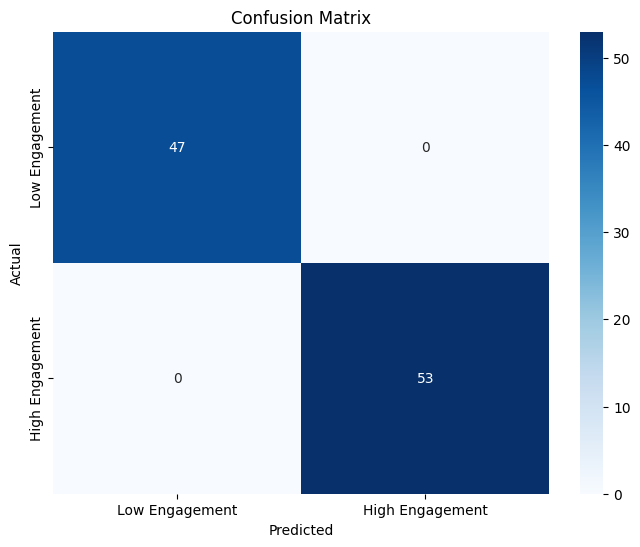

In [12]:
# Confusion matrix to evaluate model performance
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Engagement', 'High Engagement'], yticklabels=['Low Engagement', 'High Engagement'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [24]:
test=[[10,5,50.0,3.5,2.0,3.9756,4.13,33.98762464,3]]
test=scaler.fit_transform(test)
y_pred = rf_classifier.predict(test)
y_pred

array([1])

In [13]:
# Based on the results, we can fine-tune the model further, experiment with other algorithms (e.g., Gradient Boosting),
# or explore hyperparameter tuning with Random Forest to improve performance.

# Save the final model (optional, if you plan to use it for deployment)
import joblib
joblib.dump(rf_classifier, 'employee_engagement_model.pkl')

print("Model saved for future predictions.")


Model saved for future predictions.


In [41]:
import random

# Function to generate random data for each row
def generate_fake_data(num_rows):
    data = []
    for _ in range(num_rows):
        total_chapters = random.randint(5, 500)  # Total chapters (between 5 and 15)
        completed_chapters = random.randint(0, total_chapters)  # Completed chapters
        completion_rate = round((completed_chapters / total_chapters) * 100, 2) if total_chapters != 0 else 0
        
        avg_course_rating = round(random.uniform(1.0, 5.0), 2)  # Average course rating (1 to 5)
        avg_quiz_rating = round(random.uniform(1.0, 5.0), 2)  # Average quiz rating (1 to 5)
        avg_instructor_rating = round(random.uniform(1.0, 5.0), 2)  # Average instructor rating (1 to 5)
        avg_satisfaction = round(random.uniform(1.0, 5.0), 2)  # Average satisfaction (1 to 5)
        
        avg_quiz_score = round(random.uniform(20.0, 100.0), 2)  # Average quiz score (20 to 100)
        total_attempts = random.randint(1, 10)  # Total quiz attempts (1 to 10)
        label = 1 if completion_rate > 70 and avg_satisfaction > 3 else 0
        
        data.append([
            total_chapters,
            completed_chapters,
            completion_rate,
            avg_course_rating,
            avg_quiz_rating,
            avg_instructor_rating,
            avg_satisfaction,
            avg_quiz_score,
            total_attempts,
            label
        ])
    
    return data

# Generate 10 rows of fake data
fake_data = generate_fake_data(1000000)
columns = ['total_chapters', 'completed_chapters', 'completion_rate', 'avg_course_rating', 'avg_quiz_rating', 'avg_instructor_rating', 'avg_satisfaction', 'avg_quiz_score', 'total_attempts', 'label']
df_with_labels = pd.DataFrame(fake_data, columns=columns)

# Display the fake data with labels
print(df_with_labels)



        total_chapters  completed_chapters  completion_rate  \
0                  465                   7             1.51   
1                  176                  93            52.84   
2                  291                 187            64.26   
3                   77                  51            66.23   
4                  141                  93            65.96   
...                ...                 ...              ...   
999995             463                 275            59.40   
999996             462                  30             6.49   
999997             204                 116            56.86   
999998             422                 361            85.55   
999999              33                  16            48.48   

        avg_course_rating  avg_quiz_rating  avg_instructor_rating  \
0                    3.01             3.14                   1.73   
1                    1.42             4.83                   2.12   
2                    4.63           

In [42]:
X = df_with_labels.drop(columns=['label'])
y = df_with_labels['label']

In [43]:

test=scaler.fit_transform(X)
y_pred = rf_classifier.predict(test)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [44]:
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print(classification_report(y, y_pred))

Accuracy: 62.36%
              precision    recall  f1-score   support

           0       1.00      0.56      0.72    849514
           1       0.29      1.00      0.44    150486

    accuracy                           0.62   1000000
   macro avg       0.64      0.78      0.58   1000000
weighted avg       0.89      0.62      0.67   1000000



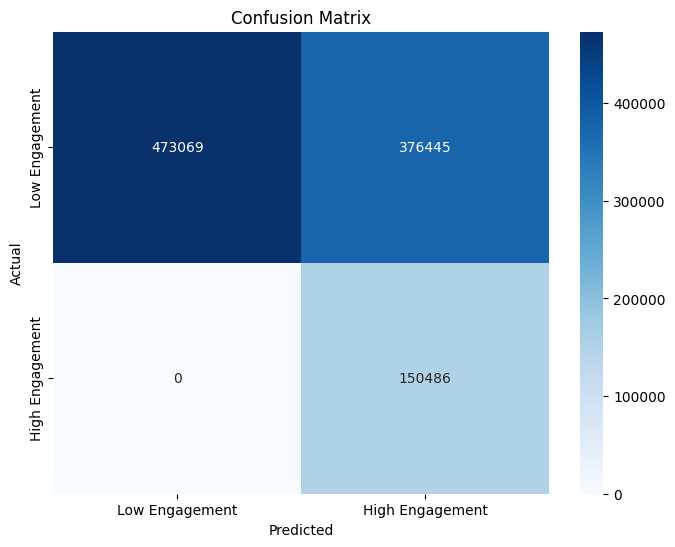

In [45]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Engagement', 'High Engagement'], yticklabels=['Low Engagement', 'High Engagement'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()